This notebook is largely based on the post ["quantum label classification using qiskit"](https://quantumcomputing.stackexchange.com/questions/17847/quantum-label-classification-using-qiskit) and its answer by [Tristan Nemoz](https://quantumcomputing.stackexchange.com/users/10454/tristan-nemoz) on Quantum Computing StackExchange

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit import execute
import numpy as np

In [2]:
qiskit.IBMQ.save_account('your_token', overwrite=True)

In [3]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

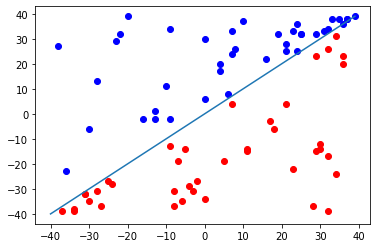

In [30]:
m, b = 1, 0

lower, upper = -40, 40
num_points = 40
x1 = [random.randrange(start=-40, stop=40) for i in range(num_points)]
x2 = [random.randrange(start=-40, stop=40) for i in range(num_points)]

y1 = [random.randrange(start=lower, stop=m*x+b) for x in x1]
y2 = [random.randrange(start=m*x+b, stop=upper) for x in x2]

plt.plot(np.arange(-40,40), m*np.arange(-40,40)+b)
plt.scatter(x1, y1, c='red')
plt.scatter(x2, y2, c='blue')
plt.show()

x1, x2, y1, y2 = np.array(x1).reshape(-1,1), np.array(x2).reshape(-1,1), np.array(y1).reshape(-1,1), np.array(y2).reshape(-1,1)

x_upper = np.concatenate((x2, y2), axis=1)
x_lower = np.concatenate((x1, y1), axis=1)
X = np.concatenate((x_upper, x_lower), axis=0)

res1 = np.array([-1]*len(x1))
res2 = np.array([1]*len(x2))
y = np.concatenate((res1, res2), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [34]:
n_wires = 1
n_qubits = 1
provider = qiskit.IBMQ.get_provider('ibm-q') # select the provider
backend = provider.get_backend('ibmq_quito') # select the name of the quatum computer to use
#backend = Aer.get_backend('qasm_simulator')
print("real device:", backend.name())

def quant_state(x1, x2, backend = backend):
    x1 = x1
    x2  = x2
    r = x1 * x1 + x2 * x2
    a = np.sqrt(1 + 2*r)
    psi = [0, 0, 0.5, 0, 0, -0.5, 0, 0, 1/(np.sqrt(2)*a), 0, x1/(np.sqrt(2)*a), x2/(np.sqrt(2)*a), x1/(np.sqrt(2)*a), x2/(np.sqrt(2)*a), 0, 0]
    qc = QuantumCircuit(4)
    qc.initialize(psi, [0,1,2,3])
    qc.h(3)
    qc.measure_all()
    job_sim = execute(qc, backend, shots=1000)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)

    quantumState_1 = 0
    for i in counts.keys():
        list_i = list(i)
        if list_i[0] == '0':
            quantumState_1 += counts[i]

    return quantumState_1

quant_res = []

for i,j in zip(X_test[:, 0], X_test[:, 1]):
    qs = quant_state(i, j, backend = backend)
    if qs >= 500:
        quant_res.append(1)
    else:
        quant_res.append(-1)

print(f1_score(y_test, quant_res))

def get_color(y,zn):
    colors = []

    for i in range(len(y)):
        if y[i] == zn:
            colors.append('red')
        else:
            colors.append('blue')

    return(colors)

colors = get_color(y_train, 1)
quantColors = get_color(quant_res, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c = colors) 
plt.scatter(X_test[:, 0], X_test[:, 1], c = quantColors, marker = "x")
plt.plot(np.arange(-40,40), m*np.arange(-40,40)+b)
plt.show()

real device: ibmq_quito
